In [1]:
import pandas as pd
import numpy as np
import os
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from time import time
from sklearn.pipeline import Pipeline
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from spacy.lang.en import English
import string
from string import digits
import sys
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to /Users/arodi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/arodi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/arodi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#separate training data and labels
train_data_path='/Users/arodi/Desktop/Fall-2021/CMPE-255/project/CMPE-255_S3-Group10/C50/C50train/'
#change the data pathname while running based on location
author_list=os.listdir(train_data_path)#lists all the authors in path 'train_data_path'
train_labels=[]
train_set=[]

for p in author_list:
    if (not p.startswith('.')):
        file_list=os.listdir(train_data_path+p)#lists all the files in the path "train_data_path+p"
        #file_list.remove('.ipynb_checkpoints') # remove .ipynb_checkpoints if data is present  in jupyter notebook
        #file_list.remove('.DS_store') # remove .DS_store files if data is prsent in local drive
        path2_each_author=train_data_path+p#path for every author folder
        
        for author in author_list:
            if (not author.startswith('.')):  # this condition is to keep out all hidden files
                if author not in train_labels:
                    train_labels.append(author)
        writings = ''
        for file in range(len(file_list)):
            with open (path2_each_author+'/'+file_list[file],'r') as fp:
                writings+=fp.read()
        train_set.append(writings)
print("Number of train labels",len(train_labels))
print("-"*50)


        
#separate test data and labels
test_data_path='/Users/arodi/Desktop/Fall-2021/CMPE-255/project/CMPE-255_S3-Group10/C50/C50test/'
author_list=os.listdir(test_data_path)#lists all the authors in path 'train_data_path'
test_labels=[]
test_set=[]

for p in author_list:
    if (not p.startswith('.')):
        file_list=os.listdir(test_data_path+p)#lists all the files in the path "test_data_path+p"
        #file_list.remove('.ipynb_checkpoints') # remove .ipynb_checkpoints if data is present  in jupyter notebook
        #file_list.remove('.DS_store') # remove .DS_store files if data is prsent in local drive
        path2_each_author=test_data_path+p#path for every author folder
        
        for author in author_list:
            if (not author.startswith('.')):  # this condition is to keep out all hidden files
                if author not in test_labels:
                    test_labels.append(author)
        writings = ''
        for file in range(len(file_list)):
            with open (path2_each_author+'/'+file_list[file],'r') as fp:
                writings+=fp.read()
        test_set.append(writings)
print("Number of test labels:",len(test_labels))
print("-"*50)




Number of train labels 50
--------------------------------------------------
Number of test labels: 50
--------------------------------------------------


In [3]:
#regex to remove emails and html tags
remover = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6})|\S*@\S*\s?;')

def preprocess(reviews):
    processed_text = []
    for review in reviews:
        #Expanding contractions
        cList = {"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will",
                  "I'll've": "I will have",
                  "I'm": "I am",
                  "I've": "I have",
                  "isn't": "is not",
                  "it'd": "it had",
                  "it'd've": "it would have",
                  "it'll": "it will",
                  "it'll've": "it will have",
                  "it's": "it is",
                  "let's": "let us",
                  "ma'am": "madam",
                  "mayn't": "may not",
                  "might've": "might have",
                  "mightn't": "might not",
                  "mightn't've": "might not have",
                  "must've": "must have",
                  "mustn't": "must not",
                  "mustn't've": "must not have",
                  "needn't": "need not",
                  "needn't've": "need not have",
                  "o'clock": "of the clock",
                  "oughtn't": "ought not",
                  "oughtn't've": "ought not have",
                  "shan't": "shall not",
                  "sha'n't": "shall not",
                  "shan't've": "shall not have",
                  "she'd": "she would",
                  "she'd've": "she would have",
                  "she'll": "she will",
                  "she'll've": "she will have",
                  "she's": "she is",
                  "should've": "should have",
                  "shouldn't": "should not",
                  "shouldn't've": "should not have",
                  "so've": "so have",
                  "so's": "so is",
                  "that'd": "that would",
                  "that'd've": "that would have",
                  "that's": "that is",
                  "there'd": "there had",
                  "there'd've": "there would have",
                  "there's": "there is",
                  "they'd": "they would",
                  "they'd've": "they would have",
                  "they'll": "they will",
                  "they'll've": "they will have",
                  "they're": "they are",
                  "they've": "they have",
                  "to've": "to have",
                  "wasn't": "was not",
                  "we'd": "we had",
                  "we'd've": "we would have",
                  "we'll": "we will",
                  "we'll've": "we will have",
                  "we're": "we are",
                  "we've": "we have",
                  "weren't": "were not",
                  "what'll": "what will",
                  "what'll've": "what will have",
                  "what're": "what are",
                  "what's": "what is",
                  "what've": "what have",
                  "when's": "when is",
                  "when've": "when have",
                  "where'd": "where did",
                  "where's": "where is",
                  "where've": "where have",
                  "who'll": "who will",
                  "who'll've": "who will have",
                  "who's": "who is",
                  "who've": "who have",
                  "why's": "why is",
                  "why've": "why have",
                  "will've": "will have",
                  "won't": "will not",
                  "won't've": "will not have",
                  "would've": "would have",
                  "wouldn't": "would not",
                  "wouldn't've": "would not have",
                  "y'all": "you all",
                  "y'alls": "you alls",
                  "y'all'd": "you all would",
                  "y'all'd've": "you all would have",
                  "y'all're": "you all are",
                  "y'all've": "you all have",
                  "you'd": "you had",
                  "you'd've": "you would have",
                  "you'll": "you you will",
                  "you'll've": "you you will have",
                  "you're": "you are",
                  "you've": "you have"}  
        review_re=re.compile('(%s)' % '|'.join(cList.keys()))
        def expand_contractions(text,cList=cList):
            def replace(match):
                return cList[match.group(0)]
            return review_re.sub(replace, text)
        review=expand_contractions(review)
        # remove html tags  and email
        removed = re.sub(remover, '', review)
        to_remove = str.maketrans('', '', digits)
        number_removed = removed.translate(to_remove)
        #remove url
        url_removed = re.sub('r^https?:\/\/.*[\r\n]*', '', number_removed, flags=re.MULTILINE)
        #punctuation removed
        punctuation_removed=url_removed.translate(str.maketrans('', '', string.punctuation))
        # lowercase
        lower = punctuation_removed.lower()
        # lemmatize
        clean_text = ""
        stop_removed = ""
        lemmatized_text = ""
        # remove stop words using dictionary dictionary is faster than sets
        words_to_remove = stopwords.words('english')
        stopword_list = Counter(words_to_remove)
        tokens = word_tokenize(lower)
        tokens = [t.strip() for t in tokens]
        words_to_keep = [t for t in tokens if t not in stopword_list]
        stop_removed = " ".join(words_to_keep)
        # lemmatization is done based on context
        lemmatizer = WordNetLemmatizer()
        tokenization = nltk.word_tokenize(stop_removed)
        for w in tokenization:
            clean_text += (lemmatizer.lemmatize(w))+" "
        processed_text.append(clean_text.strip())
    
    return processed_text


In [4]:
# clean train and test data
processed_train = preprocess(train_set)
print(len(processed_train))
processed_test = preprocess(test_set)
print(len(processed_test))

50
50


In [5]:
# extract features from text
count_vectorizer = CountVectorizer(strip_accents='ascii',ngram_range=(1, 2))
cvmattrain = count_vectorizer.fit_transform(processed_train)
cvmattest = count_vectorizer.transform(processed_test)


#use tf-idf to normalize
tfidf_trasnformer =  TfidfTransformer()
tfidftrain = tfidf_trasnformer.fit_transform(cvmattrain)
tfidftest = tfidf_trasnformer.fit_transform(cvmattest)

#convert to csr matrix

compressed_train = csr_matrix(tfidftrain)
compressed_test = csr_matrix(tfidftest)

print(compressed_train.shape)
print(compressed_test.shape)

(50, 409046)
(50, 409046)


In [6]:
# check which hyperparameters work best for our data(not using gridsearch cv here)
clist=[0.1,1,10,100]
alphalist=[0.01,0.1,1,10]
klist=[9,11,13,19]

knn_scores=[]
lr_scores=[]
lsvc_scores=[]
mnb_scores=[]

In [7]:
for k in klist:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(compressed_train, train_labels)
    predicted_labelsk = knn.predict(compressed_test)
    score = metrics.accuracy_score(test_labels, predicted_labelsk)
    knn_scores.append(score)
for c in clist:
    lr=LogisticRegression(C=c,max_iter=4000)
    lr.fit(compressed_train, train_labels)
    predicted_labelslr = lr.predict(compressed_test)
    score = metrics.accuracy_score(test_labels, predicted_labelslr)
    lr_scores.append(score)
for c in clist:
    lsvc=LinearSVC(C=c,max_iter=4000)
    lsvc.fit(compressed_train, train_labels)
    predicted_labelsls = lsvc.predict(compressed_test)
    score = metrics.accuracy_score(test_labels, predicted_labelsls)
    lsvc_scores.append(score)
for a in alphalist:
    nb=MultinomialNB(alpha=a)
    nb.fit(compressed_train, train_labels)
    predicted_labelsmn = nb.predict(compressed_test)
    score = metrics.accuracy_score(test_labels, predicted_labelsmn)
    mnb_scores.append(score)

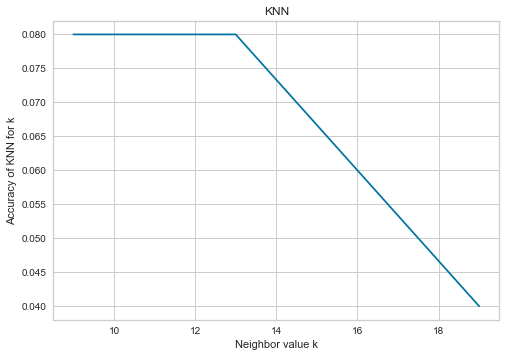

In [8]:
plt.title("KNN")
plt.xlabel("Neighbor value k")
plt.ylabel("Accuracy of KNN for k")
plt.plot(klist,knn_scores)

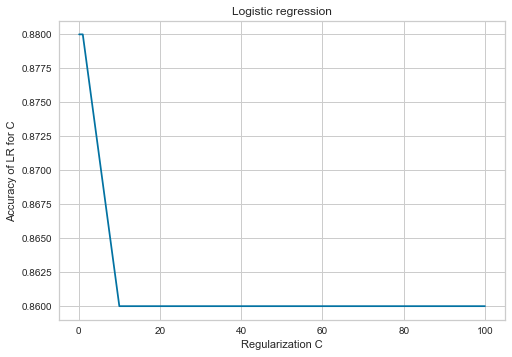

In [9]:
plt.title("Logistic regression")
plt.xlabel("Regularization C")
plt.ylabel("Accuracy of LR for C")
plt.plot(clist,lr_scores)

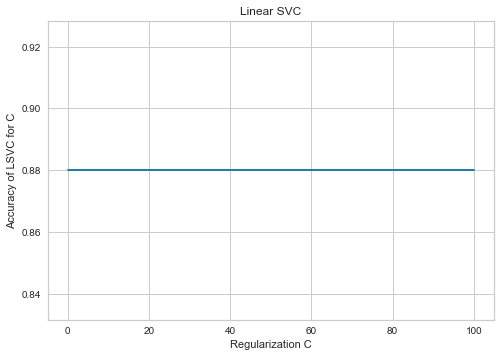

In [10]:
plt.title("Linear SVC")
plt.xlabel("Regularization C")
plt.ylabel("Accuracy of LSVC for C")
plt.plot(clist,lsvc_scores)

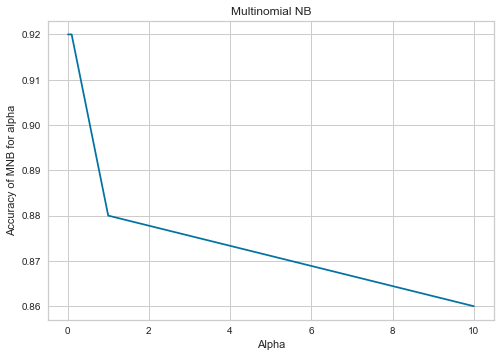

In [11]:
plt.title("Multinomial NB")
plt.xlabel("Alpha")
plt.ylabel("Accuracy of MNB for alpha")
plt.plot(alphalist,mnb_scores)

In [12]:
# function to calculate accuracy, training and testing time. Also plots confusion matrix and classification report
def select_best_clf(classifier):
    print("=" * 100)
    print("Training: ")
    print(classifier)
    start_time = time()
    classifier.fit(compressed_train, train_labels)
    train_time = time() - start_time
    print("train time: %0.3fs" % train_time)

    start_time = time()
    predicted_labels = classifier.predict(compressed_test)
    test_time = time() - start_time
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(test_labels, predicted_labels)
    print("accuracy:   %0.3f" % score)

    print("classification report:")
    visualizer = ClassificationReport(classifier, classes=test_labels, support=True,zero_division=1)
    visualizer.fit(compressed_train, train_labels)        # Fit the visualizer and the model
    visualizer.score(compressed_test, test_labels)        # Evaluate the model on the test data
    visualizer.show()
    print("confusion matrix:")
    cm=metrics.confusion_matrix(test_labels, predicted_labels)
    df_cm = pd.DataFrame(cm, range(50), range(50))
    plt.rcParams["figure.figsize"] = (22,15)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()


    print()
    classifier_description = str(classifier).split("(")[0]
    return classifier_description, score, train_time, test_time




kNN
Training: 
KNeighborsClassifier(n_neighbors=13)
train time: 0.002s
test time:  0.041s
accuracy:   0.080
classification report:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


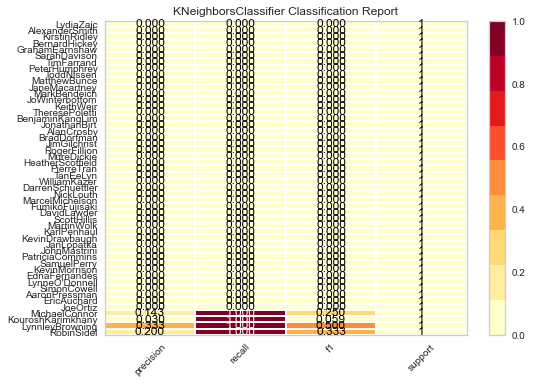

confusion matrix:


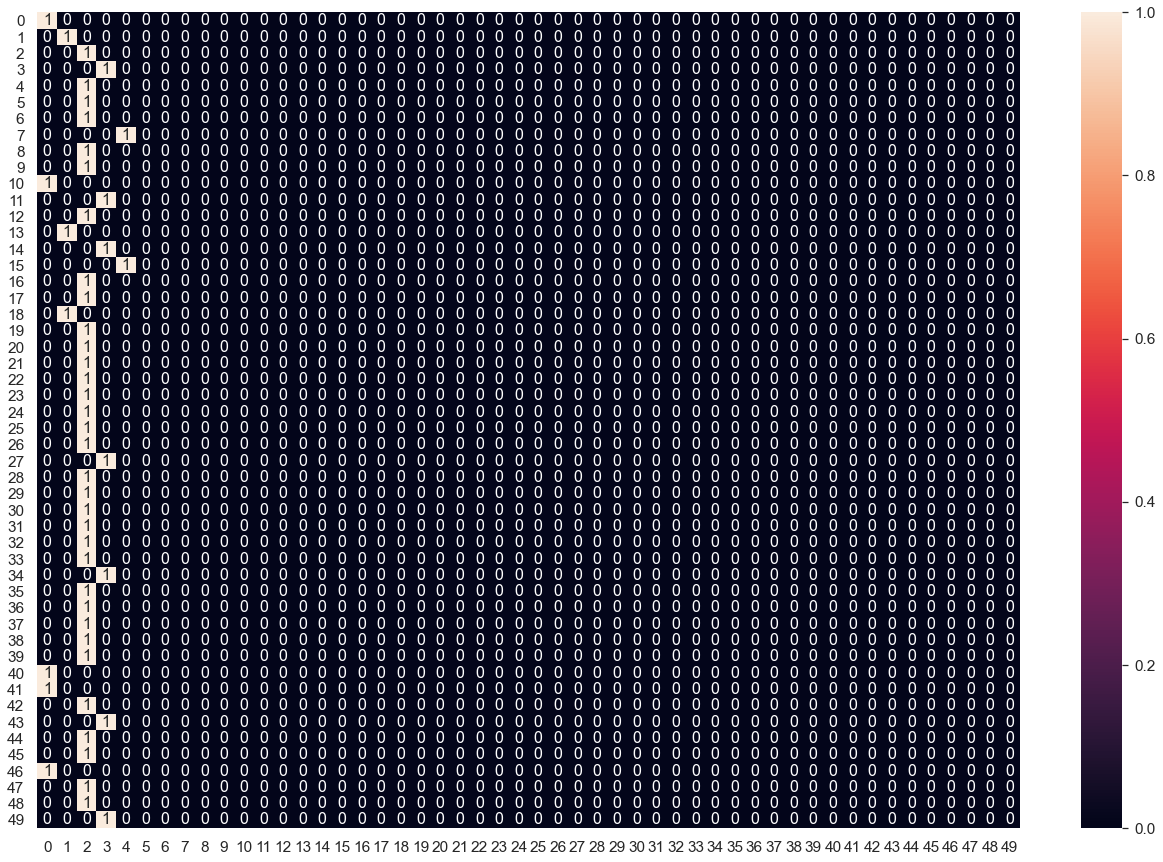


Logistic Regression
Training: 
LogisticRegression(C=10, max_iter=4000)
train time: 119.527s
test time:  0.119s
accuracy:   0.860
classification report:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


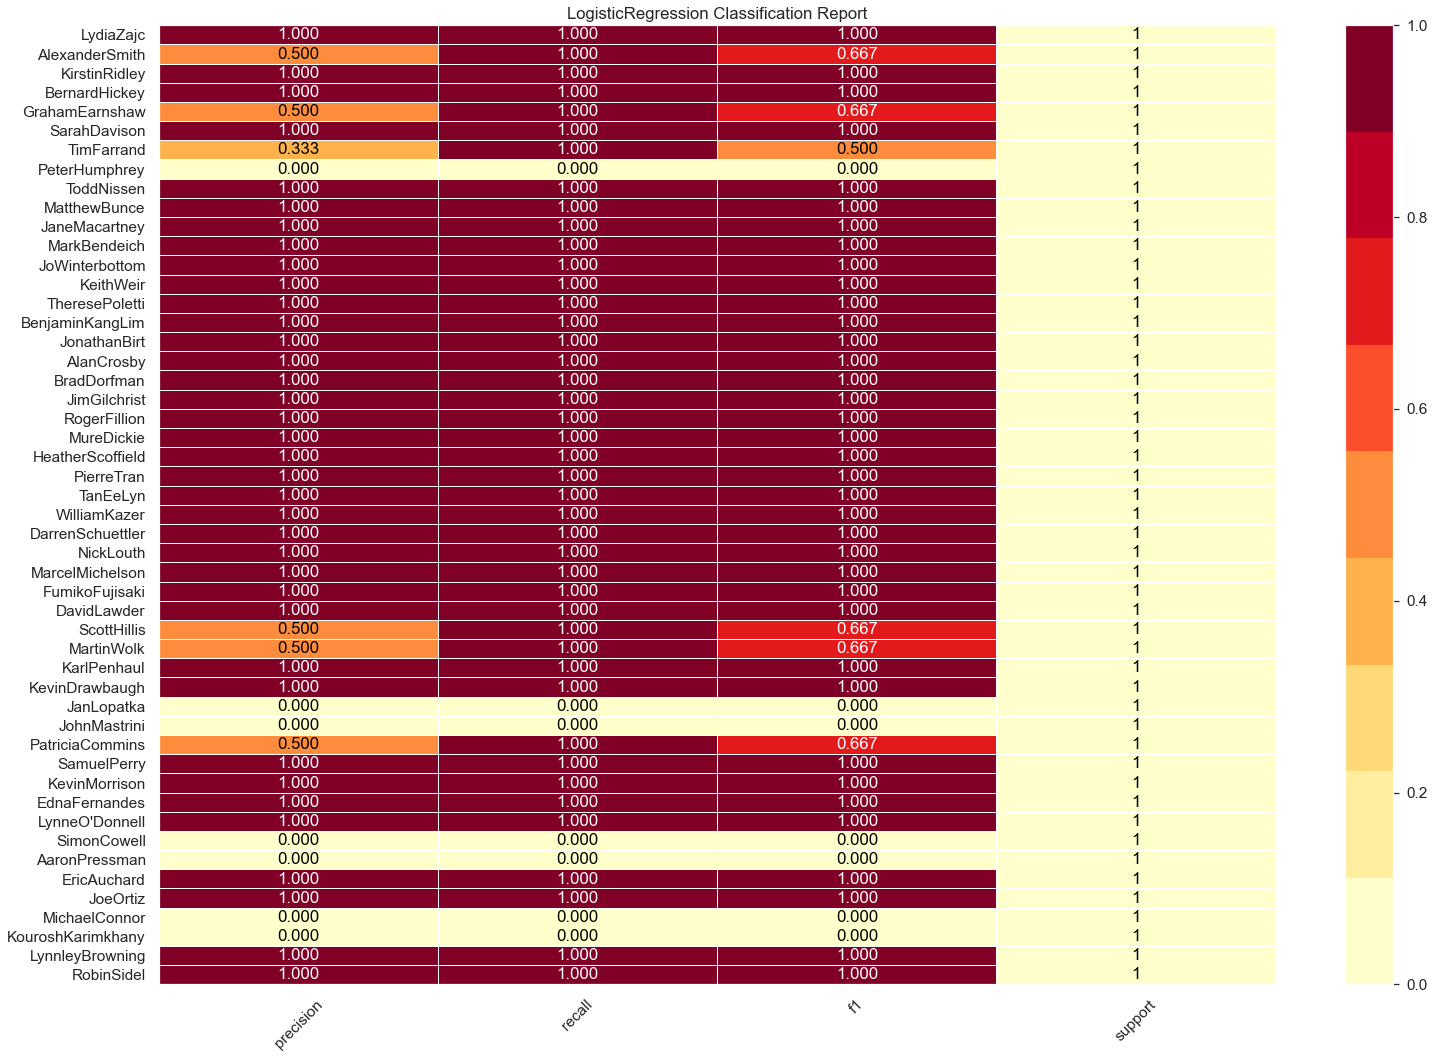

confusion matrix:


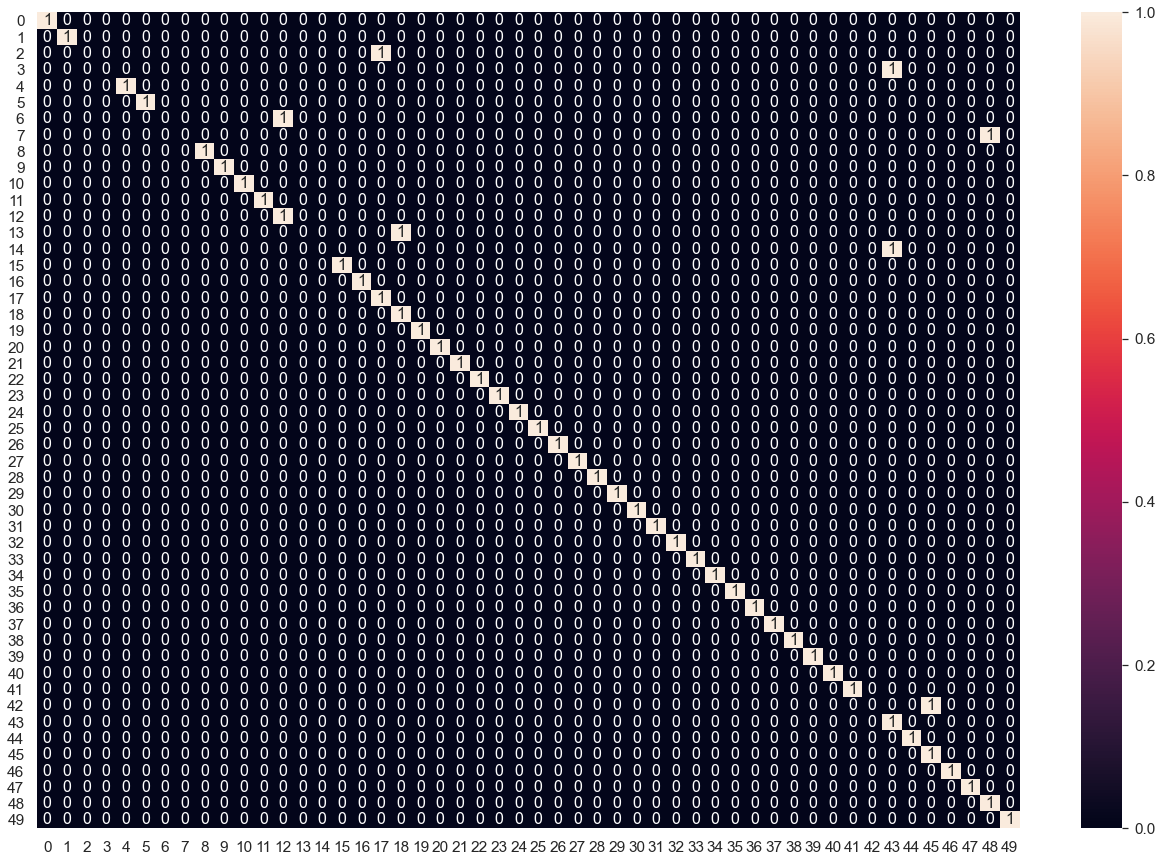


LinearSVC
Training: 
LinearSVC(C=10, max_iter=4000)
train time: 4.378s
test time:  0.020s
accuracy:   0.880
classification report:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


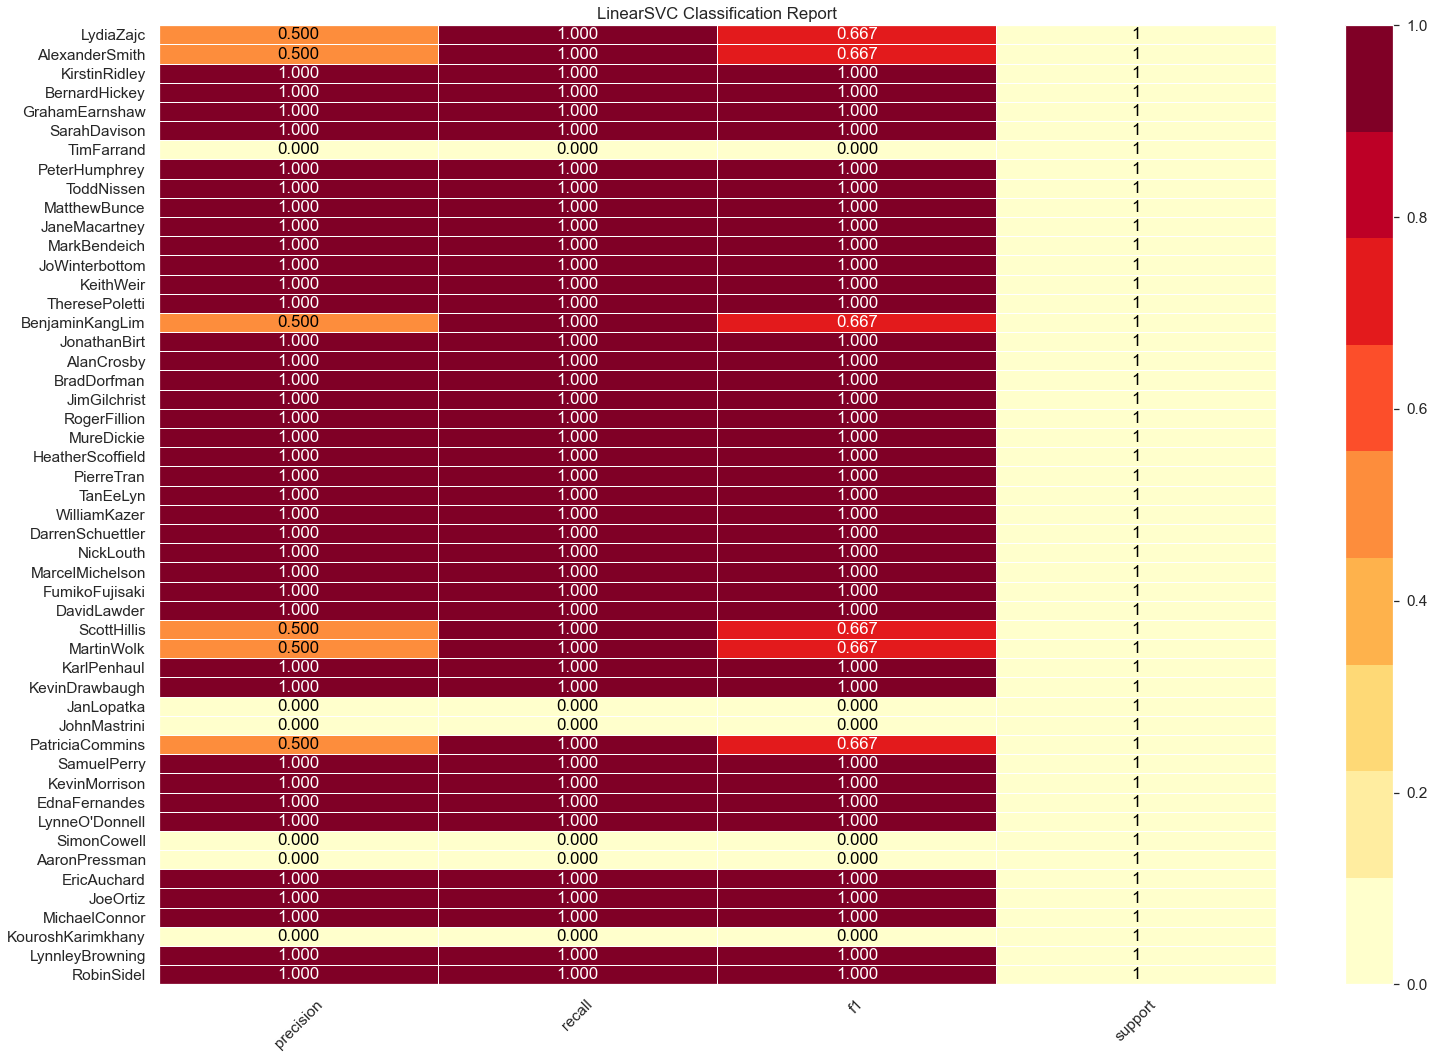

confusion matrix:


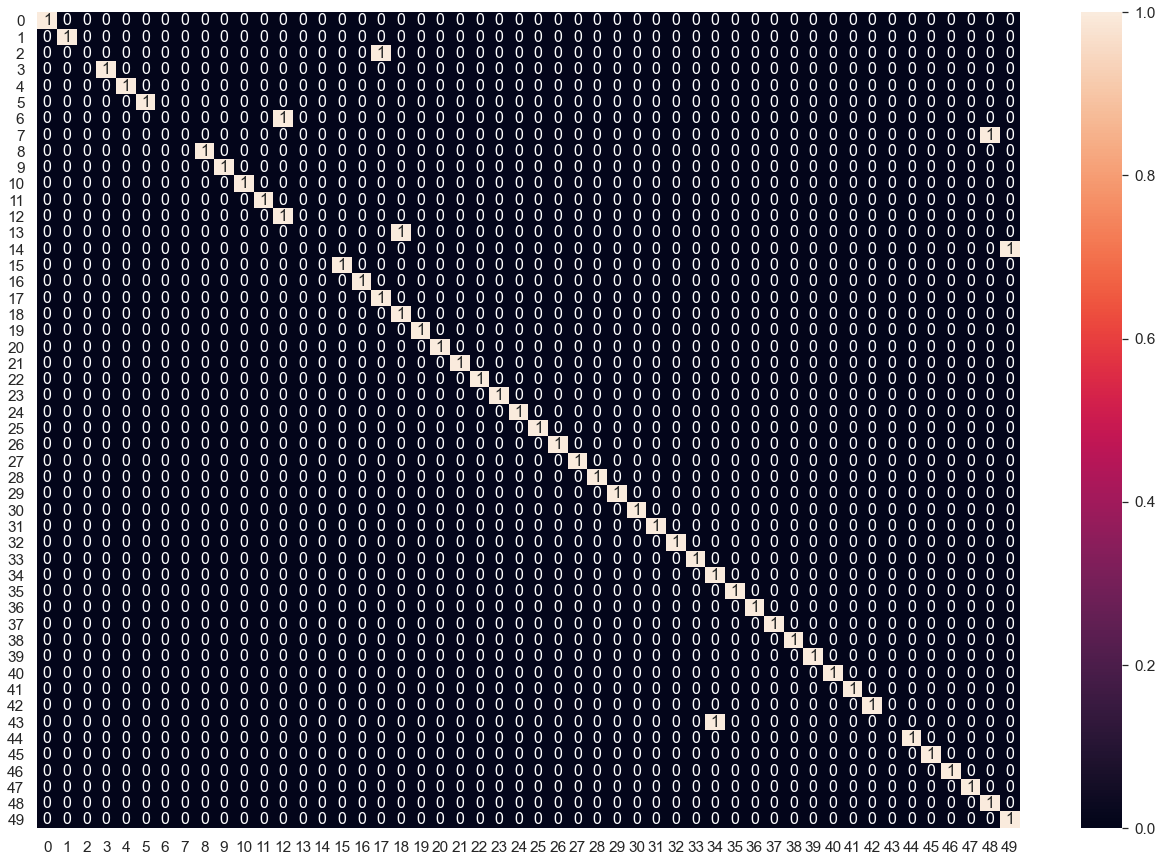


Multinomial NB
Training: 
MultinomialNB(alpha=0.01)
train time: 0.661s
test time:  0.105s
accuracy:   0.920
classification report:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


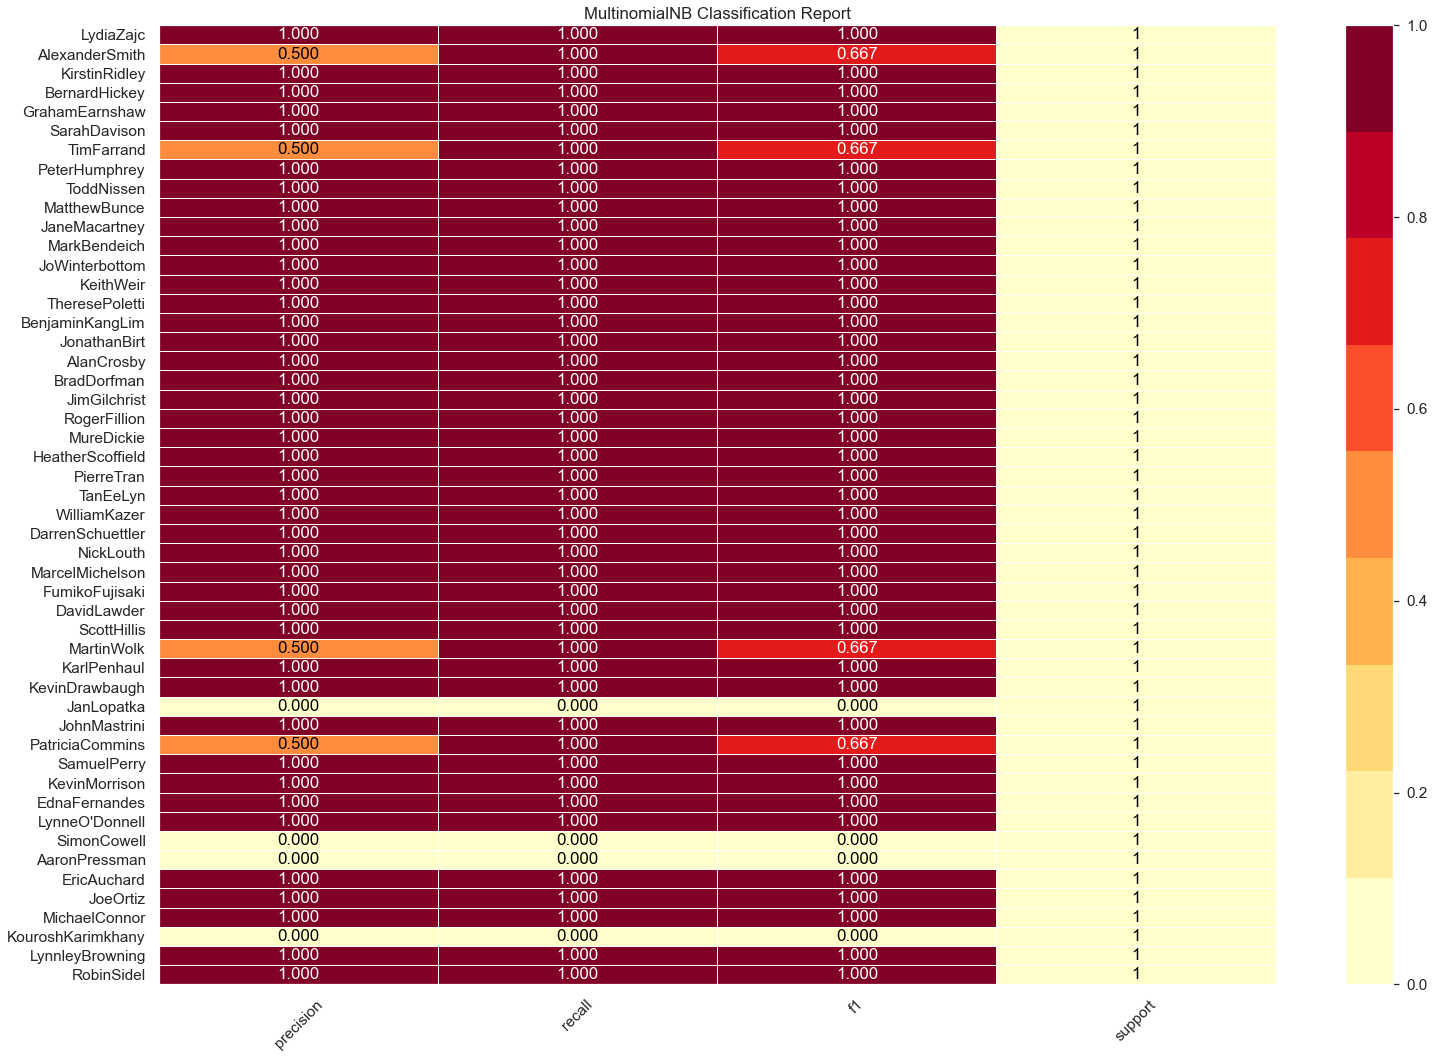

confusion matrix:


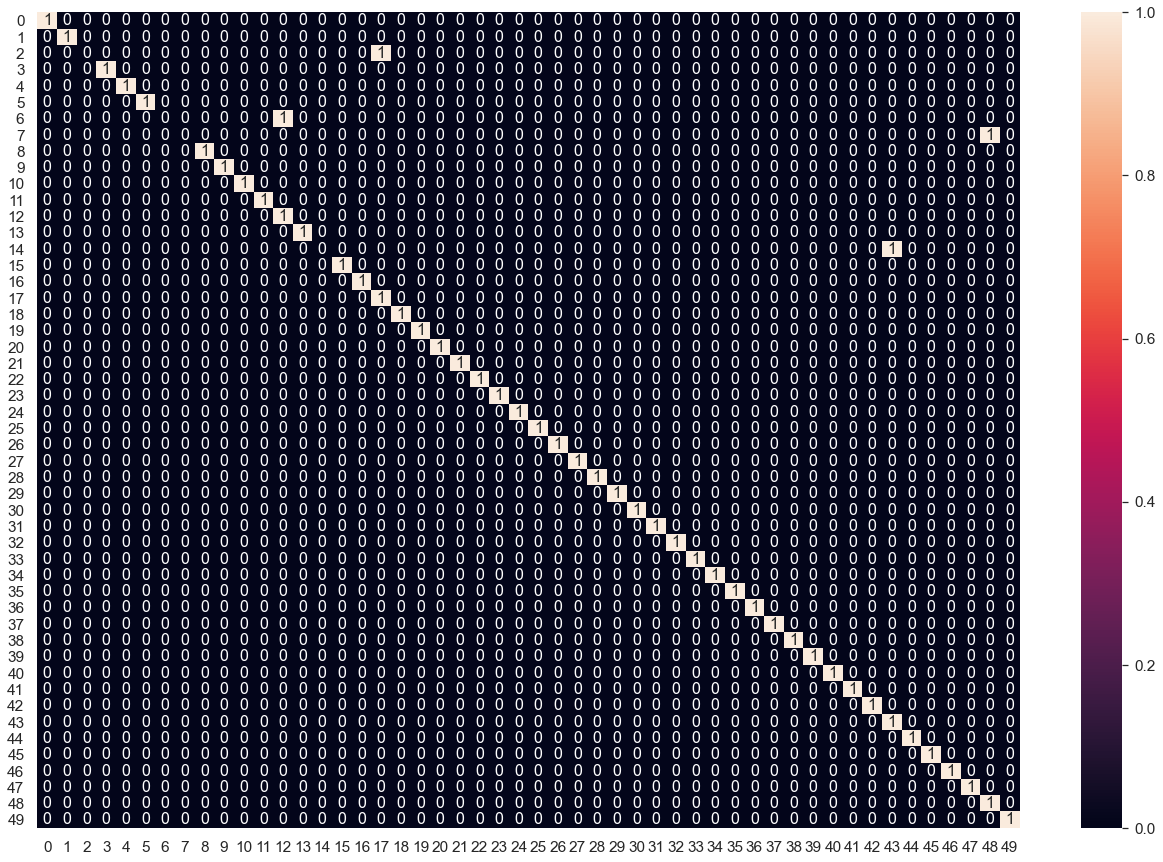

In [13]:
# run the algorithms using best hyperparameters found out in previous step
test_results = []
for classifier, name in (
    (KNeighborsClassifier(n_neighbors=13), "kNN"),
    (LogisticRegression(C=10,max_iter=4000), "Logistic Regression"),
    (LinearSVC(C=10,max_iter=4000), "LinearSVC"),
    (MultinomialNB(alpha=0.01), "Multinomial NB"),
):
    print("=" * 100)
    print(name)
    test_results.append(select_best_clf(classifier))

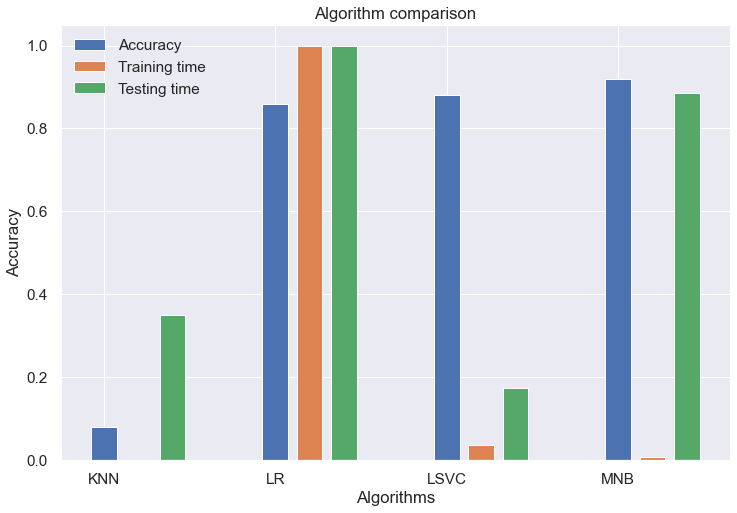

In [14]:
# compare all 4 algorithms 

test_results = [[x[i] for x in test_results] for i in range(4)]

clf_names, score, training_time, test_time = test_results
training_time = np.array(training_time).astype(float) / np.max(training_time).astype(float)
test_time = np.array(test_time).astype(float) / np.max(test_time).astype(float)



labels = ['KNN','LR','LSVC','MNB']
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
acc = ax.bar(x, score, width, label='Accuracy')
trt = ax.bar(x+0.2, training_time, width, label='Training time')
tst = ax.bar(x+0.4, test_time, width, label='Testing time')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Algorithms')
ax.set_title('Algorithm comparison')
ax.set_xticks(x, labels)
ax.legend(loc='best')

plt.show()

